In [1]:
####### importing all required packages here ##########
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.optimization.applications.ising import max_cut
from qiskit.optimization.converters import IsingToQuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer,GroverOptimizer
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.aqua.algorithms import QAOA
from qiskit.optimization import QuadraticProgram
from docplex.mp.model import Model

In [2]:
from qiskit import IBMQ
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

In [3]:
###### Fucntion for creating random adjacency matrix. #########

def create_adjacency_matrix(number_of_vertices, probability):
    adj_matrix = np.ones((number_of_vertices,number_of_vertices))
    for i in range(0,number_of_vertices):
        for j in range(i,number_of_vertices):
            if random.random()>probability or i==j:
                adj_matrix[i,j]=0
                adj_matrix[j,i]=0
    return adj_matrix

In [4]:
###### Function for converting binary number to decimal #######

def dec_to_bin(decimal, no_bits):
    binary = np.zeros((no_bits))
    for i in range(no_bits-1,-1,-1):
        #print(decimal, i)
        if int(decimal/(2**i)):
            binary[i]=1
        decimal = decimal%(2**i)
    
    return binary

In [5]:
####### Using Brute force ########

def brute_force(n, adj_matrix):
    best_cost = 0
    best_case = None
    for k in range(2**n):
        binary_k=dec_to_bin(k, n)
        temp_cost = 0
        for i in range(n):
            for j in range(n):
                temp_cost = temp_cost + adj_matrix[i,j]*binary_k[i]*(1-binary_k[j])
        if temp_cost > best_cost:
            best_cost = temp_cost
            best_case = binary_k

    return best_cost

In [6]:
######## Function for getting cost using numpyeigensolver ############

def using_numpyeigensolver(n, adj_matrix):
    qubitop, offset = max_cut.get_operator(adj_matrix)
    qudratic = QuadraticProgram()
    qudratic.from_ising(qubitop, offset)
    solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    result = solver.solve(qudratic)
    best_cost = -1*result.fval
    return best_cost


In [7]:
def using_vqe(n, adj_matrix):
    qubitop, offset = max_cut.get_operator(adj_matrix)
    qudratic = QuadraticProgram()
    qudratic.from_ising(qubitop, offset)
    vqe = VQE(quantum_instance = BasicAer.get_backend('qasm_simulator'))
    vqe_optimizer = MinimumEigenOptimizer(vqe)
    result = vqe_optimizer.solve(qudratic)
    return -1*result.fval
#using_vqe(5,create_adjacency_matrix(5,0.5))

In [8]:
def using_qaoa(n, adj_matrix):
    operator, offset = max_cut.get_operator(adj_matrix)
    qudratic = QuadraticProgram()
    qudratic.from_ising(operator, offset)
    qaoa_API = QAOA(p = 4,quantum_instance = BasicAer.get_backend('qasm_simulator') )
    qaoa_optimiser = MinimumEigenOptimizer(qaoa_API)
    result = qaoa_optimiser.solve(qudratic)
    return -1*result.fval
#using_qaoa(5,create_adjacency_matrix(5,0.5))

In [9]:
def using_grover(n,adj_matrix):
    qubitop, offset = max_cut.get_operator(adj_matrix)
    qudratic = QuadraticProgram()
    qudratic.from_ising(qubitop, offset)
    backend = BasicAer.get_backend('qasm_simulator')
    grover_optimizer = GroverOptimizer(n, num_iterations=10, quantum_instance=backend)
    solver = MinimumEigenOptimizer(grover_optimizer)
    results = grover_optimizer.solve(qudratic)
    print("x={}".format(results.x))
    print("fval={}".format(results.fval))
#using_grover(5,create_adjacency_matrix(5,0.5))

In [10]:
def main_function(n1,n2):
    cost_vs_n = list()
    time_vs_n = list()
    cost_brute = list()
    cost_numpy = list()
    cost_qaoa = list()
    cost_vqe = list()
    time_brute = list()
    time_numpy = list()
    time_qaoa = list()
    time_vqe = list()
    print( "n & brute_force & Numpysolver & QAOA & VQE")
    for i in range(n1,n2):
        for j in range(5):
            adj_matrix = create_adjacency_matrix(i,0.5)
            initial_time = time.time()
            cost_brute.append(brute_force(i,adj_matrix))
            final_time = time.time()
            time_brute.append(final_time - initial_time)

            initial_time = time.time()
            cost_numpy.append(using_numpyeigensolver(i, adj_matrix))
            final_time = time.time()
            time_numpy.append(final_time - initial_time)

            initial_time = time.time()
            cost_qaoa.append(using_qaoa(i,adj_matrix))
            final_time = time.time()
            time_qaoa.append(final_time - initial_time)

            initial_time = time.time()
            cost_vqe.append(using_vqe(i,adj_matrix))
            final_time = time.time()
            time_vqe.append(final_time - initial_time)

        (n, cb, cn, cq, cv) = (i, sum(cost_brute)/5.0, sum(cost_numpy)/5.0, sum(cost_qaoa)/5.0, sum(cost_vqe)/5.0)
        (n, tb, tn, tq, tv) = (i, sum(time_brute)/5.0, sum(time_numpy)/5.0, sum(time_qaoa)/5.0, sum(time_vqe)/5.0)

        print(n,'&', cb, '&', tb, '&', cn, '&', tn, '&', cq, '&', tq, '&', cv, '&', tv)    

        cost_vs_n.append((n, cb, cn, cq, cv))
        time_vs_n.append((n, tb, tn, tq, tv))

        cost_brute.clear()
        cost_numpy.clear()
        cost_qaoa.clear()
        cost_vqe.clear()
        time_brute.clear()
        time_numpy.clear()
        time_qaoa.clear()
        time_vqe.clear()

    return cost_vs_n, time_vs_n
        

In [11]:
cost_vs_n, time_vs_n = main_function(4,16)

n & brute_force & Numpysolver & QAOA & VQE
4 & 2.4 & 0.00039825439453125 & 2.4 & 0.022146940231323242 & 2.4 & 1.297603464126587 & 2.4 & 0.9948624610900879
5 & 4.4 & 0.0007977962493896484 & 4.4 & 0.02354264259338379 & 4.4 & 0.7248224258422852 & 4.4 & 1.2100250720977783
6 & 5.6 & 0.0027864456176757814 & 5.6 & 0.025930023193359374 & 5.6 & 1.315636968612671 & 5.6 & 3.7369540691375733
7 & 8.0 & 0.006382465362548828 & 8.0 & 0.03032574653625488 & 8.0 & 2.689577913284302 & 8.0 & 13.462628173828126
8 & 11.6 & 0.021344089508056642 & 11.6 & 0.07220602035522461 & 11.6 & 12.317132616043091 & 11.6 & 18.98663182258606
9 & 13.2 & 0.05355815887451172 & 13.2 & 0.10302863121032715 & 13.2 & 15.95673851966858 & 13.0 & 32.568083953857425
10 & 18.2 & 0.1358356475830078 & 18.2 & 0.07698898315429688 & 18.2 & 26.945956563949586 & 17.8 & 80.91733875274659
11 & 19.4 & 0.25632009506225584 & 19.4 & 0.05284991264343262 & 19.4 & 21.337763833999634 & 18.8 & 116.22765583992005
12 & 24.4 & 0.6657903671264649 & 24.4 & 0.

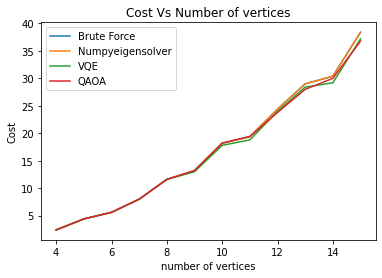

In [12]:
#### plotting cost vs n #####
plt.title("Cost Vs Number of vertices")
plt.ylabel('Cost')
plt.xlabel('number of vertices')
n, cb, cn, cq, cv = zip(*cost_vs_n)
plt.plot(n, cb, label = 'Brute Force')
plt.plot(n, cn, label = 'Numpyeigensolver')
plt.plot(n, cv, label = 'VQE')
plt.plot(n, cq, label = 'QAOA')
plt.legend()


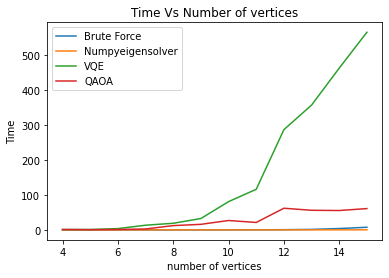

In [13]:
######### Plotting Time Vs n ########
plt.title("Time Vs Number of vertices")
plt.ylabel('Time')
plt.xlabel('number of vertices')
n, tb, tn, tq, tv = zip(*time_vs_n)
plt.plot(n, tb, label = 'Brute Force')
plt.plot(n, tn, label = 'Numpyeigensolver')
plt.plot(n, tv, label = 'VQE')
plt.plot(n, tq, label = 'QAOA')
plt.legend()

In [ ]:
import qiskit
qiskit.__qiskit_version__